In [102]:
#Problems

#How to deal with MasVnrArea. one third is zero with all range of prices

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor

import joblib
import datetime

# Load the data

In [104]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# Pre-Processing

In [105]:
df_train['Price'] = df_train.SalePrice/df_train.LotArea

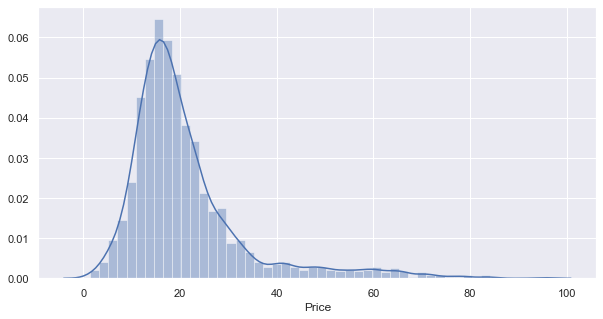

In [106]:
plt.figure(figsize=(10,5))
sns.distplot(df_train.Price);

In [107]:
# Remove the outliers
q = df_train.Price.quantile(0.99)
df_train = df_train[df_train.Price<q]

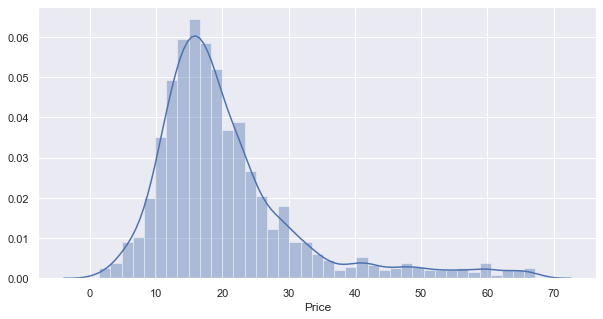

In [108]:
plt.figure(figsize=(10,5))
sns.distplot(df_train.Price);

In [109]:
df_group = df_train.groupby('BsmtCond').mean()
df_group

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Price
BsmtCond,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Fa,714.688889,61.333333,61.395349,9005.466667,5.066667,5.266667,1929.288889,1974.222222,29.755556,217.755556,13.066667,640.911111,871.733333,1031.488889,440.933333,38.088889,1510.511111,0.177778,0.066667,1.355556,0.155556,3.066667,1.088889,6.644444,0.444444,1950.078947,1.244444,327.466667,53.111111,33.511111,58.466667,0.000000,11.244444,0.000000,17.777778,6.244444,2007.711111,121809.533333,14.580813
Gd,731.369231,56.923077,70.500000,11200.400000,6.723077,5.953846,1982.553846,1993.507692,96.890625,450.369231,104.769231,579.015385,1134.153846,1218.507692,419.092308,0.000000,1637.600000,0.538462,0.153846,1.738462,0.415385,2.892308,1.000000,6.769231,0.692308,1988.063492,2.030769,536.030769,132.907692,59.800000,12.353846,0.000000,12.938462,0.000000,45.846154,6.876923,2007.169231,213599.907692,22.763299
Po,387.500000,30.000000,60.000000,9493.500000,3.000000,1.500000,1921.000000,1950.000000,0.000000,175.000000,0.000000,647.000000,822.000000,990.500000,0.000000,0.000000,990.500000,0.500000,0.000000,0.500000,0.500000,1.500000,1.000000,5.000000,0.000000,1920.000000,0.500000,169.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2008.000000,64000.000000,6.779833
TA,729.982253,55.597994,70.919887,10664.645062,6.155093,5.589506,1972.403549,1985.230710,107.240497,464.109568,46.259259,582.136574,1092.505401,1169.037037,343.359568,5.220679,1517.617284,0.442130,0.052469,1.560957,0.396605,2.866512,1.037037,6.519290,0.626543,1979.070617,1.783951,479.219907,95.956019,47.736111,21.494599,3.584105,15.807870,3.108025,42.063272,6.307099,2007.844136,183612.250000,20.847806


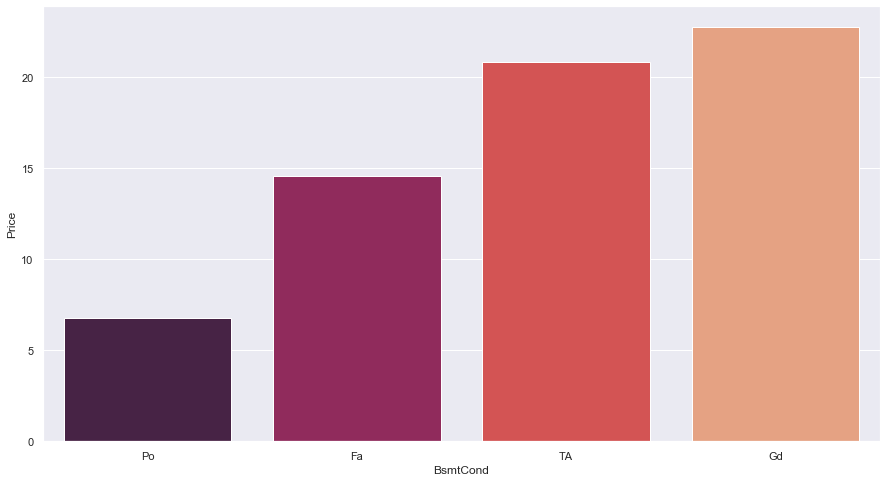

In [110]:
plt.figure(figsize=(15,8))
sns.barplot(df_group.index, df_group.Price, order = df_group.sort_values('Price').index, palette='rocket');

In [111]:
df_raw = pd.concat([df_train, df_test], axis = 0, ignore_index=True)

In [112]:
df_raw.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Price
2899,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,NaN
2900,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,NaN
2901,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,NaN
2902,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN,NaN
2903,2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,2Story,7,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,94.0,TA,TA,PConc,Gd,TA,Av,LwQ,758.0,Unf,0.0,238.0,996.0,GasA,Ex,Y,SBrkr,996,1004,0,2000,0.0,0.0,2,1,3,1,TA,9,Typ,1,TA,Attchd,1993.0,Fin,3.0,650.0,TA,TA,Y,190,48,0,0,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal,NaN,NaN


In [113]:
df_raw.MasVnrType.fillna(value = 'None', inplace = True)
df_raw.BsmtQual.fillna(value = 'TA', inplace = True)
df_raw.BsmtCond.fillna(value = 'TA', inplace = True)
df_raw.BsmtFinType1.fillna(value = 'Rec', inplace = True)
df_raw.BsmtFinType2.fillna(value = 'Rec', inplace = True)
df_raw.BsmtExposure.fillna(value = 'Av', inplace = True)
df_raw.Electrical.fillna(value = 'SBrkr', inplace = True)

for i in range(0,len(df_raw)):
    if df_raw.Condition2[i] == df_raw.Condition1[i]:
        df_raw.Condition2[i] = 'JustOne'
    
    if df_raw.Exterior1st[i] == df_raw.Exterior2nd[i]:
        df_raw.Exterior2nd[i] = 'JustOne'
    
    if df_raw.YearBuilt[i] > 1969:
        df_raw.YearBuilt[i] = 1
    else:
        df_raw.YearBuilt[i] = 0
    
    if df_raw.YearRemodAdd[i] > 1969:
        df_raw.YearRemodAdd[i] = 1
    else:
        df_raw.YearRemodAdd[i] = 0


## Create dummies for categorical data

In [114]:
pd.options.display.max_columns = 100
df = pd.get_dummies(df_raw)
df.fillna(value = -1, inplace = True)
df.tail()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Price,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,...,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
2899,2915,160,21.0,1936,4,7,1,1,0.0,0.0,0.0,546.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,5,0,-1.0,0.0,0.0,0,0,0,0,0,0,0,6,2006,-1.0,-1.0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2900,2916,160,21.0,1894,4,5,1,1,0.0,252.0,0.0,294.0,546.0,546,546,0,1092,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,286.0,0,24,0,0,0,0,0,4,2006,-1.0,-1.0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2901,2917,20,160.0,20000,5,7,0,1,0.0,1224.0,0.0,0.0,1224.0,1224,0,0,1224,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,576.0,474,0,0,0,0,0,0,9,2006,-1.0,-1.0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2902,2918,85,62.0,10441,5,5,1,1,0.0,337.0,0.0,575.0,912.0,970,0,0,970,0.0,1.0,1,0,3,1,6,0,-1.0,0.0,0.0,80,32,0,0,0,0,700,7,2006,-1.0,-1.0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2903,2919,60,74.0,9627,7,5,1,1,94.0,758.0,0.0,238.0,996.0,996,1004,0,2000,0.0,0.0,2,1,3,1,9,1,1993.0,3.0,650.0,190,48,0,0,0,0,0,11,2006,-1.0,-1.0,0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Split the data

In [115]:
df.Price[:len(df_train)].shape
x_test = df[len(df_train):]

In [116]:
x_train, x_valid, y_train,  y_valid = train_test_split(df[:len(df_train)].drop(['Price', 'SalePrice'], axis = 1), df.Price[:len(df_train)], test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1156, 290), (1156,), (289, 290), (289,))

In [117]:
#x_train = df[:len(df_train)].drop(['Price', 'SalePrice'], axis = 1)
#y_train = df.Price[:len(df_train)]

# Build and Train the Model

In [118]:
# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": np.sqrt(mean_absolute_error(y_train, train_preds)),
              "Valid RMSLE": np.sqrt(mean_absolute_error(y_valid, val_preds)),
              "Training R^2": model.score(x_train, y_train),
              "Valid R^2": model.score(x_valid, y_valid)}
    return scores

In [119]:
model_RF = RandomForestRegressor(n_jobs = -1, random_state = 42)
model_GB = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)
model_LGBM = LGBMRegressor()

In [120]:
model_RF.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [121]:
model_GB.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=4, max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=15, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [122]:
model_LGBM.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [123]:
show_scores(model_RF)

{'Training MAE': 0.8336251438792933,
 'Valid MAE': 2.0184400339406863,
 'Training RMSLE': 0.9130307464041358,
 'Valid RMSLE': 1.4207181402166604,
 'Training R^2': 0.9859017607705448,
 'Valid R^2': 0.9284118537938842}

In [124]:
show_scores(model_GB)

{'Training MAE': 0.4229983624714574,
 'Valid MAE': 2.1772402742954133,
 'Training RMSLE': 0.6503832427664917,
 'Valid RMSLE': 1.4755474490152505,
 'Training R^2': 0.9856273734040012,
 'Valid R^2': 0.9021771940250298}

In [125]:
show_scores(model_LGBM)

{'Training MAE': 0.6086800287833115,
 'Valid MAE': 1.9804214519767607,
 'Training RMSLE': 0.780179484979778,
 'Valid RMSLE': 1.4072744764177174,
 'Training R^2': 0.9917675345092378,
 'Valid R^2': 0.9281480749158908}

# Find the optimal hyperparameters for RandomForest

In [126]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestRegressor(),
                                X = x_train, y = y_train, 
                                param_name = 'max_features', 
                                param_range = [0.5, 10, 'sqrt', 'auto'], cv = 3)

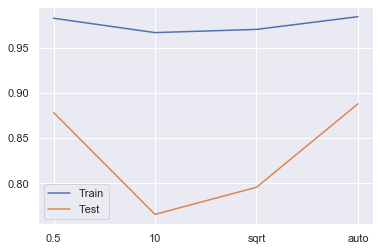

In [127]:
plt.plot([0.5, 10, 'sqrt', 'auto'],np.mean(train_scoreNum, axis = 1));
plt.plot([0.5, 10, 'sqrt', 'auto'],np.mean(test_scoreNum, axis = 1));
plt.legend(['Train', 'Test']);

In [128]:
## Different RandomForestClassifier hyperparameters
#rf_grid = {'n_estimators': np.arange(10, 100, 10),
#            'max_depth': [5, 10, 15, 20],
#            'min_samples_split': np.arange(2, 4, 2),
#            'min_samples_leaf': np.arange(1, 20, 2),
#            'max_features': [0.5, 1, 'sqrt', 'auto']}

## Instantiate RandomizedSearchCV model
#rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state= 42),
#                                param_distributions=rf_grid,
#                                n_iter = 100,
#                                cv = 5,
#                                verbose = True)

## Fit the RandomizedSearchCV model
#rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [129]:
rs_model.best_params_

{'n_estimators': 70,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 15}

In [130]:
show_scores(rs_model)

{'Training MAE': 0.8622888639763729,
 'Valid MAE': 2.038840551070869,
 'Training RMSLE': 0.9285951022789065,
 'Valid RMSLE': 1.4278797397087994,
 'Training R^2': 0.9858106874974513,
 'Valid R^2': 0.92764480466879}

In [131]:
show_scores(model)

{'Training MAE': 0.46620945063422253,
 'Valid MAE': 0.411498487427128,
 'Training RMSLE': 0.6827953211865343,
 'Valid RMSLE': 0.6414814786314006,
 'Training R^2': 0.9865584623038147,
 'Valid R^2': 0.9922506367611502}

# Save the results

In [132]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("models",
                          datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  joblib.dump(model,model_path)
  return model_path

In [133]:
save_model(model_LGBM, suffix='RandomForest')

Saving model to: models\20200726191938-RandomForest.h5...


'models\\20200726191938-RandomForest.h5'

# Test dataset and submssion to Kaggle

In [139]:
y_preds = model_LGBM.predict(x_test.drop(['Price', 'SalePrice'], axis =1))

In [140]:
SalePrice = x_test.LotArea*y_preds

In [141]:
SalePrice

1445    129774.203255
1446    169176.148752
1447    192013.096128
1448    199826.172191
1449    211242.041849
            ...      
2899     87281.002731
2900     79661.207897
2901    190079.560382
2902    121915.144798
2903    226436.142438
Name: LotArea, Length: 1459, dtype: float64

In [142]:
submission =  pd.DataFrame()
submission['Id'] = x_test.Id
submission['SalePrice'] = SalePrice

In [143]:
submission.to_csv('data/submission6.csv', index=False)